
# Introduction: Alzheimer_classification Kaggle problem
 ***This is the code based on youtube tutorial: [Deep Learning with PyTorch: Zero to GANs](https://www.youtube.com/watch?v=d9QHNkD_Pos&list=PLCHu_nIKtwrQLzC8ywaXExdtYSkjOKwxg&index=6&t=5293s)*** \

In the above tutorial [Aakash Rao N S]https://jovian.ai/aakashns) applied his code for the [CIFAR10 data set](https://www.cs.toronto.edu/~kriz/cifar.html). 

With this project, I do the imgage classification with a [Kaggle MRI with 4 classes data set](https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images)

NOTE that Aakash does not do the image transformation with his tutorial, tt.Compose. 

I here, I would like to test the testing accuracy using **Resnet34**, when
- Doing no image transformation
- Doing image transformation using torchvision.transforms
- Doing image transformation using monai.transform

## About Dataset
The data consists of MRI images. The data has four classes (from most healthy to leas healthy) of images both in training as well as a testing set:

NOD: Non Demented \
VMD: Very Mild Demented \
MID: Mild Demented \
MOD: Moderate Demented 

Reference: \

NOTE: can use CenterCrop to crop the image

In [1]:
import os
import torch
import torchvision
# from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import pandas as pd
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import glob
import cv2
import torchvision.transforms as tt


In [2]:
from mymodule import *

In [ ]:
project_name='Kaggle-MRI-Dementia-Brain-Classification'

# S1. Explore the data

Get the subfolder and classes

In [ ]:
data_dir = './Data'
subfolders = os.listdir(data_dir) # list the subfolder in the main folder 
print("Subfolder in the data folder: ", subfolders) 
classes = os.listdir(data_dir + "/" + subfolders[1]) # get the class from the train folder 
print("The classes avaiable in each subfolder:", classes)

Subfolder in the data folder:  ['test', 'train']
The classes avaiable in each subfolder: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


Get the number of images in each subfolder

In [ ]:
df = num_files_f(data_dir)
print(df)

      MildDemented ModerateDemented NonDemented VeryMildDemented
test           179               12         640              448
train          717               52        2560             1792


Check the images' sizes

In [ ]:
imag = []  
for f in glob.iglob("./data/train/VeryMildDemented/*.jpg"):   #go to the directory and read all of file ending with .jpg
    img = cv2.imread(f) 
    imag.append(img)
len(imag)
sizes = []
for img in imag:
    sizes.append(img.shape) 
print(min(sizes), max(sizes))

(208, 176, 3) (208, 176, 3)


In [ ]:
find_min_max_img_size(data_img_dir="./data/train/VeryMildDemented/*.jpg")

((208, 176, 3), (208, 176, 3))

Load the data as a Pytorch tensors (with ***torchvision.transforms*** image transformation)

In [9]:
trainset = ImageFolder(data_dir+'/train', transform=ToTensor())
print(len(trainset)), print(trainset.classes), print(trainset.classes[0])
#
random_seed = 42
torch.manual_seed(random_seed)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])
#
print(len(trainset)), print(trainset.classes), print(trainset.classes[0])
testset = ImageFolder(data_dir+'/test', transform=ToTensor())
print(len(testset))

5121
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
MildDemented
4096


AttributeError: 'Subset' object has no attribute 'classes'

Label:  MildDemented (0)


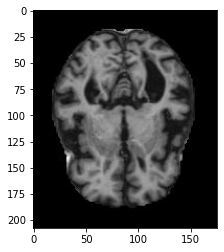

In [ ]:
show_example(trainset, 0)

Label:  MildDemented (0)


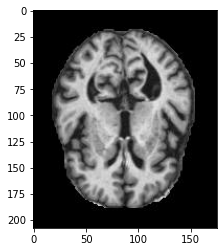

In [ ]:
show_example(trainset,80)

Label:  MildDemented (0)


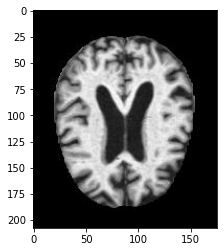

In [ ]:
show_example(testset, 0)

Label:  VeryMildDemented (3)


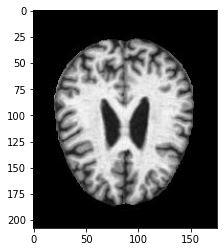

In [ ]:
show_example(testset, 1278)

Split into train + val + test

In [ ]:
print(len(trainset))
print(len(valset))
print(len(testset))

4096
1025
1279


Create data loader

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32 # start with a smaller number, like, 16, 32, then keep doubling the batchs_ize, and check the training time
#
train_dl = DataLoader(trainset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(valset, 
                    batch_size*2, #the valid-batch_size = 2*training-batch_size since we dont need to compute the gradient
                    num_workers=4, pin_memory=True)

Draw a batch 

tensor([3, 2, 0, 2, 3, 3, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2,
        3, 2, 2, 3, 2, 3, 3, 3])


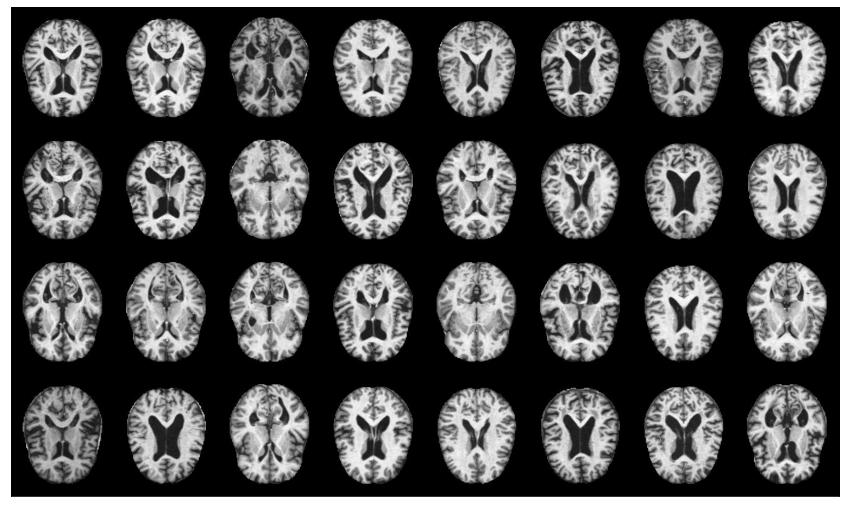

In [ ]:
show_batch(train_dl)

tensor([3, 2, 3, 3, 2, 3, 2, 2, 2, 0, 0, 3, 3, 2, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3,
        3, 2, 3, 3, 2, 1, 0, 2, 2, 3, 2, 2, 2, 2, 3, 0, 2, 2, 3, 0, 3, 2, 2, 3,
        0, 0, 2, 2, 0, 2, 3, 2, 3, 0, 3, 2, 1, 3, 2, 2])


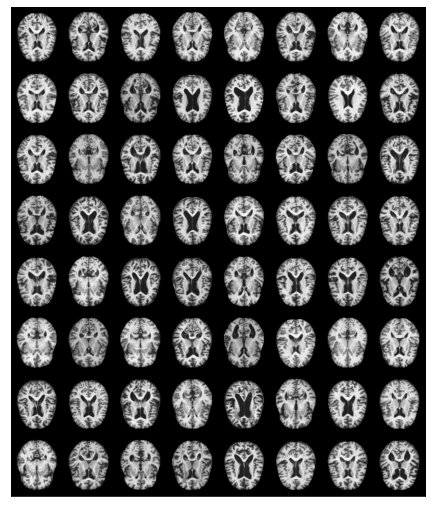

In [ ]:
show_batch(val_dl)

# S2 Define model

In [ ]:
from torchvision import models

class Resnet34_No_Transform_model(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=False):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)
    

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# S3. Train Model

In [ ]:
model = Resnet34_No_Transform_model(len(classes), pretrained=False)
to_device(model, device);

In [ ]:
model

Resnet34_No_Transform_model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

In [ ]:
# check if our model works
# history = [evaluate(model, val_dl)]
# history

In [ ]:
%%time
epochs = 70
lr = 0.001
opt_func = torch.optim.Adam
history = fit(epochs, lr , model, train_dl, val_dl, opt_func=opt_func)

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.9290, val_loss: 0.8323, val_acc: 0.5983
CPU times: total: 7.19 s
Wall time: 20 s


# S4. Plot train+validation history

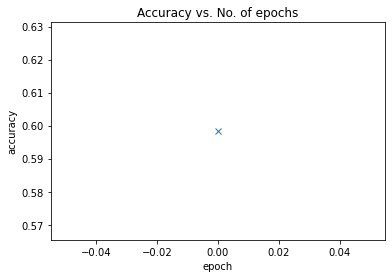

In [ ]:
plot_accuracies(history)

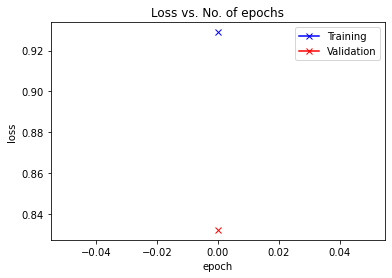

In [ ]:
plot_losses(history)

# S5. Save model


In [ ]:
torch.save(model.state_dict(), './model/Resnet34_No_Transform_cnn.pth')

# S6 Prediction Testing_Accuracy

In [ ]:
Resnet34_No_Transform_trainedmodel = to_device(Resnet34_No_Transform_model(4), device)  #  redefine the model with the same structure of the MRIModel
Resnet34_No_Transform_trainedmodel.load_state_dict(torch.load('./model/Resnet34_No_Transform_cnn.pth'))

<All keys matched successfully>

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [ ]:
def predict_image(img, model, dataset):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: MildDemented , Predicted: VeryMildDemented


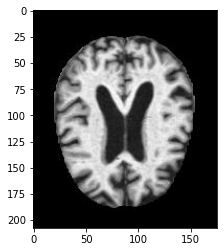

In [ ]:
img, label = testset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, Resnet34_No_Transform_trainedmodel, testset))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(testset, batch_size*2), device)
result = evaluate(Resnet34_No_Transform_trainedmodel, test_loader)
result

{'val_loss': 0.9595879912376404, 'val_acc': 0.5525793433189392}